# Q1 -> RNN for Auto-Regressive Models

## Analysis of RNN's

- This Model performs very poorly, because of the excessive amount of noise, present in it
- The Model, would work well if teacher forcing could be used even in the output, because it could use the ground truths as Illustrated by the results
- But, in it's absence the Model performance is quite poor
- Which is Illustrated by the extremely low R^2 Loss

### Import Libraries 

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Testing for GPU

### Generate the Toy Dataset

/var/folders/w9/n4f5mch54rs7r4cqyz2rxynm0000gp/T/ipykernel_56934/3854634798.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[0] = np.random.uniform(0,1,1) # Generate X(0)
/var/folders/w9/n4f5mch54rs7r4cqyz2rxynm0000gp/T/ipykernel_56934/3854634798.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[1] = np.random.uniform(0,1,1) + a1*X[0] # Generate X(1), considering X(0)
/var/folders/w9/n4f5mch54rs7r4cqyz2rxynm0000gp/T/ipykernel_56934/3854634798.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing thi

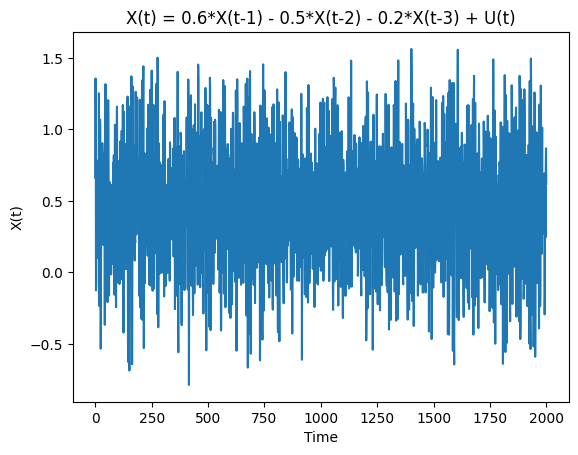

In [2]:
# Generate Data Samples of the Form -> X(t) = a1*X(t-1) + a2*X(t-2) + a3*X(t-3) + U(t)
# where U(t) ~ N(0,1)

# Generate Data Function
def gen_data(n, a1, a2, a3):
    X = np.zeros(n) # Generate X(t)
    U = np.random.uniform(0,1,n) # Generate U(t)
    X[0] = np.random.uniform(0,1,1) # Generate X(0)
    X[1] = np.random.uniform(0,1,1) + a1*X[0] # Generate X(1), considering X(0)
    X[2] = np.random.uniform(0,1,1) + a1*X[1] + a2*X[0] # Generate X(2), considering X(0) and X(1)
    for i in range(3,n):
        X[i] = a1*X[i-1] + a2*X[i-2] + a3*X[i-3] + U[i]
    return X

# Generate Training Data -> 2000 Samples
X_train = gen_data(2000, a1 = 0.6, a2 = -0.5, a3 = -0.2)
X_test = gen_data(2000, a1 = 0.6, a2 = -0.5, a3 = -0.2)

# Plot the Data
plt.plot(X_train.reshape(-1,1))
plt.title("X(t) = 0.6*X(t-1) - 0.5*X(t-2) - 0.2*X(t-3) + U(t)")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.show()
    

### Create a Custom RNN Class

Epoch: 0, Loss: 0.30570
Epoch: 10, Loss: 0.16184
Epoch: 20, Loss: 0.05825
Epoch: 30, Loss: 0.00723
Epoch: 40, Loss: 0.00149
Epoch: 50, Loss: 0.00162
Epoch: 60, Loss: 0.00065
Epoch: 70, Loss: 0.00035
Epoch: 80, Loss: 0.00029
Epoch: 90, Loss: 0.00021
Epoch: 100, Loss: 0.00017
Epoch: 110, Loss: 0.00016
Epoch: 120, Loss: 0.00015
Epoch: 130, Loss: 0.00016
Epoch: 140, Loss: 0.00014
Epoch: 150, Loss: 0.00011
Epoch: 160, Loss: 0.00012
Epoch: 170, Loss: 0.00011
Epoch: 180, Loss: 0.00012
Epoch: 190, Loss: 0.00010
Epoch: 200, Loss: 0.00009
Epoch: 210, Loss: 0.00009
Epoch: 220, Loss: 0.00008
Epoch: 230, Loss: 0.00008
Epoch: 240, Loss: 0.00008
Epoch: 250, Loss: 0.00008
Epoch: 260, Loss: 0.00007
Epoch: 270, Loss: 0.00008
Epoch: 280, Loss: 0.00007
Epoch: 290, Loss: 0.00007


[]

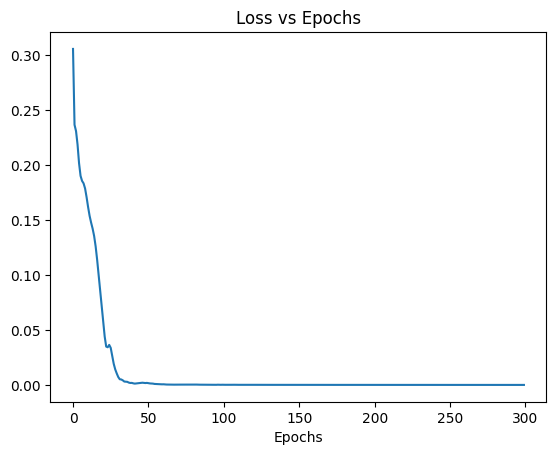

In [3]:
# Define the RNN Class
class C_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, p):
        super(C_RNN, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.p = p

        # Define the RNN Layer
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, train = True):
        outputs = []
        hidden_states = []
        self.initial_hidden = torch.rand(self.num_layers,x.shape[0],self.hidden_size)
        for timestep in range(self.p):
            h_t = []
            if(timestep== 0):
                h_t = self.rnn_cell(x[:,timestep], self.initial_hidden[0])
            else:
                input = []
                if(train):
                    input = x[:,timestep]
                elif (train == False and timestep > 3):
                    # Now, you have to predict the next using previous
                    input = outputs[-1]
                else:
                    input = x[:,timestep]
                h_t = self.rnn_cell(input, hidden_states[-1])
            hidden_states.append(h_t)
            out = self.fc(h_t)
            outputs.append(out)
        # Convert the List to a Tensor
        outputs = torch.stack(outputs, dim = 1)
        return outputs
    
    def predict(self, x):
        return self.forward(x, False)
    
# Create the Model
model = C_RNN(input_size = 1, hidden_size = 10, output_size = 1, num_layers=1, p=2000) # Input Size = 1, Hidden Size = 10, Output Size = 1

# Define the Loss Function and the Optimizer
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr = 0.02) # Adam Optimizer

# Train the Model
epochs = 300
# Store the Losses in a List
losses = []

for epoch in range(epochs):
    inputs = torch.tensor(X_train.reshape(1,-1,1), dtype = torch.float) # Here inputs dimension is (batch_size, seq_length, input_size)
    labels = torch.tensor(X_train.reshape(1,-1,1), dtype = torch.float) # Here labels dimension is (batch_size, seq_length, output_size)
    outputs = model(inputs) 
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch%10 == 0:
        print("Epoch: %d, Loss: %1.5f" % (epoch, loss.item()))

# Plot the Losses vs Epochs
plt.plot(losses)
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.plot()


# Analysis by giving the entire Dataset

In [13]:
Final_Seq = model(torch.tensor(X_test.reshape(1,-1,1), dtype = torch.float))
Final_Seq = Final_Seq.detach().numpy()

# Find out the MSE Loss between the Predicted and the Actual
MSE = np.mean((X_test - Final_Seq)**2)

# R^2 Score
R2 = 1 - (np.sum((X_test - Final_Seq)**2))/(np.sum((X_test - np.mean(X_test))**2))

# Find out the MAE Loss
MAE = np.mean(np.abs(X_test - Final_Seq))

# Print the Results
print("MSE Loss: %1.5f" % MSE)
print("R2 Score: %1.5f" % R2)
print("MAE Loss: %1.5f" % MAE)

MSE Loss: 0.00009
R2 Score: 0.99950
MAE Loss: 0.00601


# By Giving only the First Token

In [14]:
# Predict the Values
# Now, we have to predict the next 2000 values given the first three tokens
Final_Seq = model.predict(torch.tensor(X_test.reshape(1,-1,1), dtype = torch.float))
Final_Seq = Final_Seq.detach().numpy()

# Reshape the Final Sequence
Final_Seq = Final_Seq.reshape(-1,1)
X_test = X_test.reshape(-1,1)

# Find out the MSE Loss between the Predicted and the Actual
MSE = np.mean((X_test - Final_Seq)**2)

# R^2 Score
R2 = 1 - (np.sum((X_test - Final_Seq)**2))/(np.sum((X_test - np.mean(X_test))**2))

# Find out the MAE Loss
MAE = np.mean(np.abs(X_test - Final_Seq))

# Print the Results
print("MSE Loss: %1.5f" % MSE)
print("R2 Score: %1.5f" % R2)
print("MAE Loss: %1.5f" % MAE)

MSE Loss: 0.48596
R2 Score: -1.61868
MAE Loss: 0.58840
